## import modules

In [156]:
# Import basic modules
# More modules will be imported before the corresponding function
# import logging # logger = logging.getLogger(__name__)
import math
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Ignore some annoying warnings
from datetime import datetime

# Import module for EMD decomposition
# It is the EMD-signal module with different name to import
from PyEMD import EMD,EEMD,CEEMDAN,Visualisation #For module 'PyEMD', please use 'pip install EMD-signal' instead.

# Import modules for LSTM prediciton
# Sklearn
from sklearn.preprocessing import MinMaxScaler # Normalization
from sklearn.metrics import r2_score # R2
from sklearn.metrics import mean_squared_error # MSE
from sklearn.metrics import mean_absolute_error # MAE
from sklearn.metrics import mean_absolute_percentage_error # MAPE
# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.layers import GRU,Flatten
#from tcn import TCN # pip install keras-tcn

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model # To use plot_model, you need to install software graphviz
from tensorflow.python.client import device_lib

# Statistical tests
from statsmodels.tsa.stattools import adfuller # adf_test
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test # LB_test
from statsmodels.stats.stattools import jarque_bera as jb_test # JB_test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # plot_acf_pacf

from sklearn.preprocessing import StandardScaler

import yfinance as yf

import keras
from xgboost import XGBRegressor as XGBR

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1"   

In [3]:
import pickle

In [127]:
data = pickle.load(open("btc_1d.pkl","rb"))

In [128]:
data = data[['open','high','low','close','trades','volume','vwap']]

In [129]:
#data['date'] = data.index
data.index = range(len(data))
data

,open,high,low,close,trades,volume,vwap
0,7259.5,7440.0,7235.5,7355.0,526550,2638019686,7332.4534
1,7355.0,7387.0,6633.5,6689.0,769064,4657038172,7012.1310
2,6689.0,6709.0,6181.0,6487.0,897103,4459083786,6414.3682
3,6487.0,6523.0,6323.5,6398.0,738884,2831018719,6427.5614
4,6398.0,6468.0,6100.0,6180.5,605433,2169153899,6303.5804
...,...,...,...,...,...,...,...
1210,50775.0,52147.0,50436.0,50700.0,111023,725148600,51141.7393
1211,50700.0,50700.0,47242.0,47536.0,144632,1063412600,48878.0054
1212,47536.0,48105.0,46000.0,46415.5,127588,942432900,47270.5958
1213,46415.5,47882.5,45872.5,47111.0,106563,740468800,47051.9595


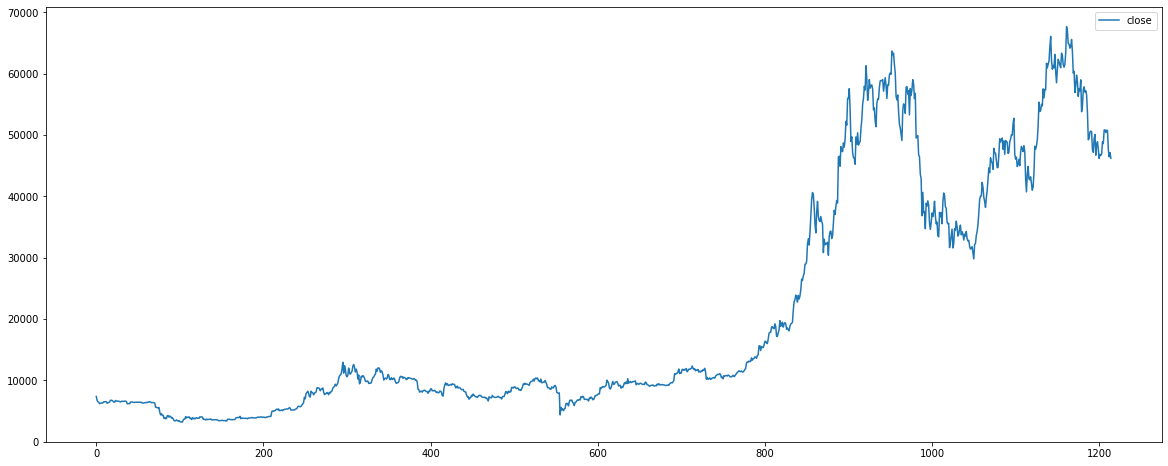

In [121]:
plt.figure(figsize = (20,8))
plt.plot(data['close'],label = 'close')
plt.legend()

# 2. evalution functions

In [8]:
SERIES = pd.Series(data['close'].values)

In [9]:
# Model evaluation function
def evl(y_test, y_pred): # MSE and MAE are different on different scales
    y_test,y_pred = np.array(y_test).ravel(),np.array(y_pred).ravel()
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)*100
    print('Model Evaluation ')
    print('R2:', r2)
    print('RMSE:', rmse)
    print('MAE:', mae)
    print("MAPE:",mape) # MAPE before normalization may error beacause of negative values
    return [r2,rmse,mae,mape]

In [10]:
# Plot original data and forecasting data
def plot_all(pred_ans,PERIODS):
    # Check and Change
    pred_ans = pred_ans.ravel()
    og = pd.Series(SERIES[-PERIODS:].values)

    # Plot
    fig = plt.figure(figsize=(10,4))
    
    plt.plot(og,label= 'Original data', color='#0070C0') #F27F19 orange #0070C0 blue
    plt.plot(pred_ans,label= 'Forecasting data', color='#F27F19')
    plt.xlabel('')
    plt.title('forecasting results')
    plt.legend()
              
    plt.show()
    return 

# 3.prediction function

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [12]:
from sklearn.compose import TransformedTargetRegressor

In [13]:
#without scaler
# DATE_BACK functions for inputting sets
def create_dateback(df,DATE_BACK=20,ahead = 1):
    trainX = df.drop('close', axis=1, inplace=False)
    #scalarX =MinMaxScaler(feature_range=(0,1))#sklearn normalize
    #trainX = scalarX.fit_transform(trainX)
    trainY = np.array(df['close']).reshape(-1, 1)
    #scalarY = MinMaxScaler(feature_range=(0,1))#sklearn normalize
    #trainY = scalarY.fit_transform(trainY)
    
    # Create dateback
    dataX, dataY = [], []
    ahead = ahead - 1
    for i in range(len(trainY)-DATE_BACK-ahead):
        dataX.append(np.array(trainX[i:(i+DATE_BACK)]))
        dataY.append(np.array(trainY[i+DATE_BACK+ahead]))
        
    return np.array(dataX),np.array(dataY)

In [14]:
def step_linear_model(df,model_type,ahead = 1):
    trainX,trainY = create_dateback(df)
    X0_train,X0_test = trainX[:-ahead],trainX[-ahead:]
    y0_train = trainY[:-ahead]
    
    X0_train = X0_train.reshape(X0_train.shape[0],-1)
    X0_test = X0_test.reshape(X0_test.shape[0],-1)
    y0_train = y0_train.reshape(y0_train.shape[0])
    
    #define linear model
    if model_type == 'LR':
        regressor = LinearRegression()
    if model_type =='Lasso':
        regressor = Lasso(alpha=0.1)
    if model_type == 'Ridge':
        regressor = Ridge()
    if model_type == 'Xgboost':
        regressor = XGBR()
    
    #print(X0_train.shape)
    #print(y0_train.shape)
    model = regressor.fit(X0_train,y0_train)
    # prediction on test set
    y_pred = model.predict(X0_test)
    
    return y_pred[0]

# bench

## 1.Lasso

In [102]:
pred_Lasso= []
for i in range(200,0,-1):
    #print(100-i)
    if (-i+1) != 0:
        df = data[:-i+1]
        pred_Lasso.append(step_linear_model(df,'Lasso'))
    elif (-i+1) == 0:
        df = data
        pred_Lasso.append(step_linear_model(df,'Lasso'))

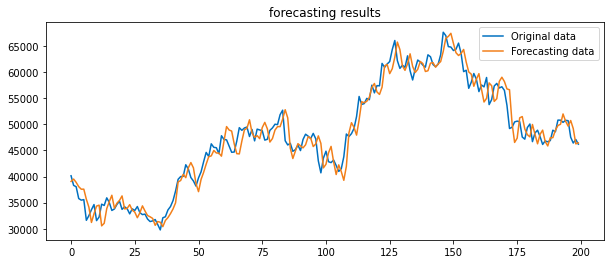

In [82]:
plot_all(pd.array(pred_Lasso[:]),PERIODS=200)

In [83]:
evl(SERIES[-200:].values, pred_Lasso)

Model Evaluation 
R2: 0.9459659647105497
RMSE: 2267.7545153542414
MAE: 1772.4308656562987
MAPE: 3.813438683085499


[0.9459659647105497, 2267.7545153542414, 1772.4308656562987, 3.813438683085499]

## 2.linear regression 

In [88]:
pred_LR= []
for i in range(200,0,-1):
    #print(100-i)
    if (-i+1) != 0:
        df = data[:-i+1]
        pred_LR.append(step_linear_model(df,'LR'))
    elif (-i+1) == 0:
        df = data
        pred_LR.append(step_linear_model(df,'LR'))

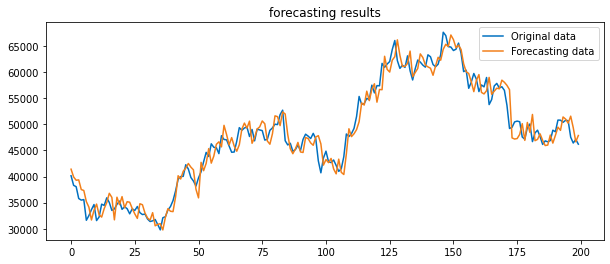

In [89]:
plot_all(pd.array(pred_LR[:]),PERIODS=200) 

In [90]:
evl(SERIES[-200:].values, pred_LR)

Model Evaluation 
R2: 0.9546901576055347
RMSE: 2076.627567684448
MAE: 1641.8242002692627
MAPE: 3.5453909053259474


[0.9546901576055347, 2076.627567684448, 1641.8242002692627, 3.5453909053259474]

## 3 Ridge

In [91]:
pred_Ridge= []
for i in range(200,0,-1):
    #print(100-i)
    if (-i+1) != 0:
        df = data[:-i+1]
        pred_Ridge.append(step_linear_model(df,'Ridge'))
    elif (-i+1) == 0:
        df = data
        pred_Ridge.append(step_linear_model(df,'Ridge'))

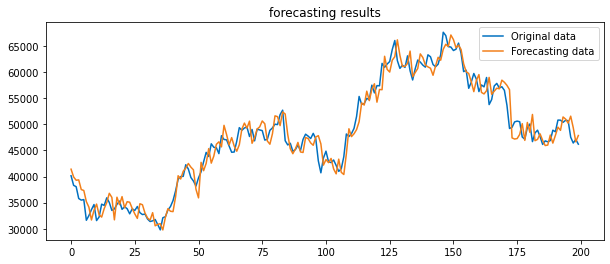

In [92]:
plot_all(pd.array(pred_Ridge[:]),PERIODS=200) 

In [93]:
evl(SERIES[-200:].values, pred_Ridge)

Model Evaluation 
R2: 0.9546901589112303
RMSE: 2076.6275377633156
MAE: 1641.8241733262466
MAPE: 3.5453908410126287


[0.9546901589112303,
 2076.6275377633156,
 1641.8241733262466,
 3.5453908410126287]

## 4.XGBOOST

In [94]:
pred_Xgboost= []
for i in range(200,0,-1):
    #print(100-i)
    if (-i+1) != 0:
        df = data[:-i+1]
        pred_Xgboost.append(step_linear_model(df,'Xgboost'))
    elif (-i+1) == 0:
        df = data
        pred_Xgboost.append(step_linear_model(df,'Xgboost'))

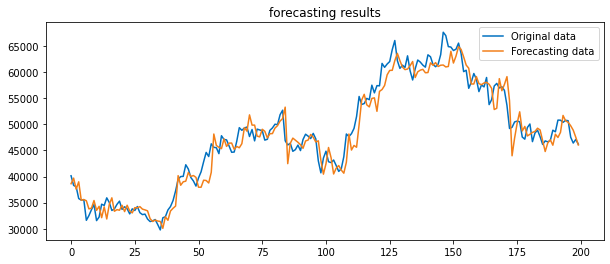

In [95]:
plot_all(pd.array(pred_Xgboost[:]),PERIODS=200) 

In [96]:
evl(SERIES[-200:].values, pred_Xgboost)

Model Evaluation 
R2: 0.9425920925429645
RMSE: 2337.48158308416
MAE: 1792.406796875
MAPE: 3.7599388678486974


[0.9425920925429645, 2337.48158308416, 1792.406796875, 3.7599388678486974]

## 5. LSTM

## 6.ARIMAX

## 7.SVR

# denoising

In [18]:
# 3.Decomposition, Sample entropy, Re-decomposition, and Integration
# EMD decomposition
# -------------------------------
# Decompose adaptively and plot function
# Residue is named the last IMF
def emd_decom(series,MODE,trials=10,draw=True): 
    # Check input
    series = series.values

    # Initialization
    print('%s decomposition is running.'%str.upper(MODE))
    if MODE == 'emd':decom = EMD()
    elif MODE == 'eemd':decom = EEMD()
    elif MODE == 'ceemdan':decom = CEEMDAN()
        
    # Decompose
    decom.trials = trials # Number of the white noise input
    imfs_emd = decom(series)
    imfs_num = np.shape(imfs_emd)[0]

    if draw:
        # Plot original data
        series_index = range(len(series))
        fig = plt.figure(figsize=(16,2*imfs_num))
        plt.subplot(1+imfs_num, 1, 1 )
        plt.plot(series_index, series, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('Original data')
    
        # Plot IMFs
        for i in range(imfs_num):
            plt.subplot(1 + imfs_num,1,2 + i)
            plt.plot(series_index, imfs_emd[i, :], color='#F27F19')
            plt.ylabel(str.upper(MODE)+'-IMF'+str(i))
    
    imfs_df = pd.DataFrame(imfs_emd.T)
    imfs_df.columns = ['imf'+str(i) for i in range(imfs_num)]

    return imfs_df # pd.DataFrame

EMD decomposition is running.


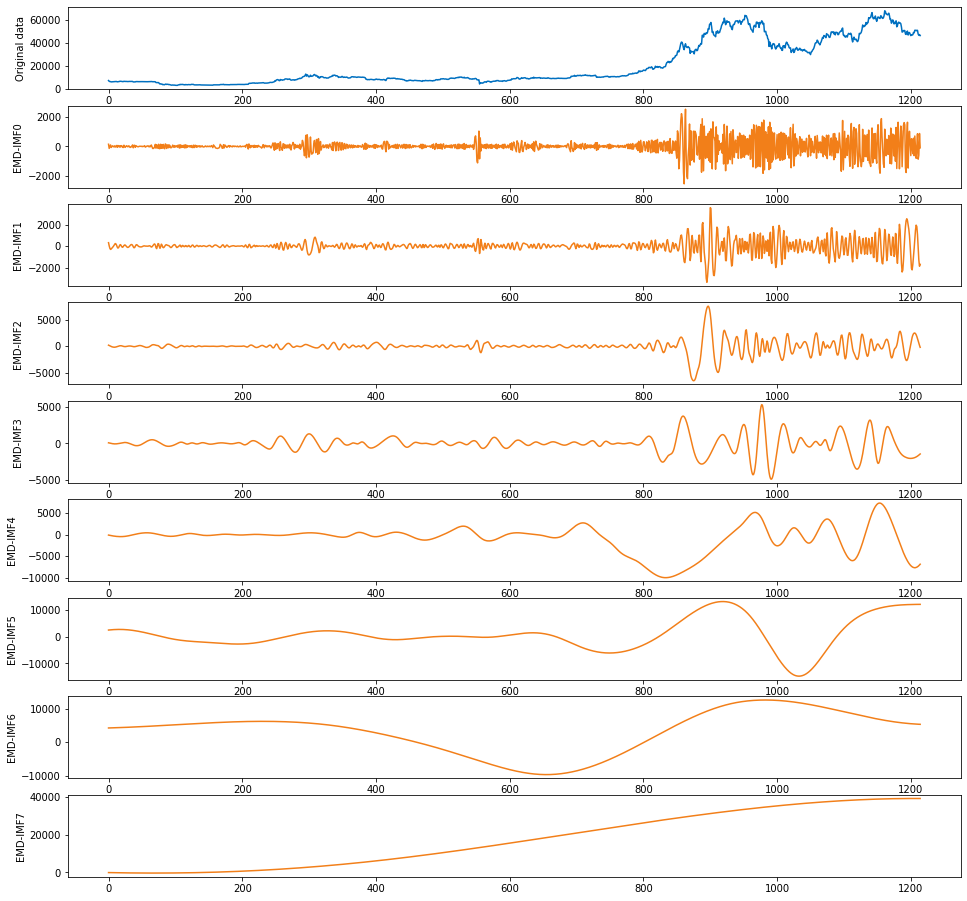

In [42]:
imfs = emd_decom(SERIES,'emd')

In [183]:
def denoise_1(imfs,df):
    denoised = imfs.iloc[:,1:].sum(axis = 1)
    de_df = df.drop(axis = 1, columns = 'close',inplace = False)
    de_df['de_close'] = pd.DataFrame(denoised)
    return de_df

In [171]:
denoise_1(imfs,data)

,open,high,low,trades,volume,vwap,de_close
0,7259.5,7440.0,7235.5,526550,2638019686,7332.4534,6736.705455
1,7355.0,7387.0,6633.5,769064,4657038172,7012.1310,6679.376586
2,6689.0,6709.0,6181.0,897103,4459083786,6414.3682,6619.142915
3,6487.0,6523.0,6323.5,738884,2831018719,6427.5614,6559.385182
4,6398.0,6468.0,6100.0,605433,2169153899,6303.5804,6503.436559
...,...,...,...,...,...,...,...
1210,50775.0,52147.0,50436.0,111023,725148600,51141.7393,47456.540462
1211,50700.0,50700.0,47242.0,144632,1063412600,48878.0054,47527.235839
1212,47536.0,48105.0,46000.0,127588,942432900,47270.5958,47613.689225
1213,46415.5,47882.5,45872.5,106563,740468800,47051.9595,47716.102451


# split train and test dataset

In [178]:
#without scaler
# DATE_BACK functions for inputting sets
def df_dateback(df,DATE_BACK=20,ahead = 1):
    trainX = df.drop('de_close', axis=1, inplace=False)
    trainY = np.array(df['de_close']).reshape(-1, 1)
    
    # Create dateback
    dataX, dataY = [], []
    ahead = ahead - 1
    for i in range(len(trainY)-DATE_BACK):
        dataX.append(np.array(trainX[i:(i+DATE_BACK)]))
        dataY.append(np.array(trainY[i+DATE_BACK]))
    dataX.append(np.array(trainX[-DATE_BACK:]))
        
    return np.array(dataX),np.array(dataY)

In [179]:
def denoise_pred(df,model_type,ahead = 1):
    trainX,trainY = df_dateback(df)
    X0_train,X0_test = trainX[:-ahead],trainX[-ahead:]
    y0_train = trainY
    
    X0_train = X0_train.reshape(X0_train.shape[0],-1)
    X0_test = X0_test.reshape(X0_test.shape[0],-1)
    y0_train = y0_train.reshape(y0_train.shape[0])
    
    #define linear model
    if model_type == 'LR':
        regressor = LinearRegression()
    if model_type =='Lasso':
        regressor = Lasso(alpha=0.1)
    if model_type == 'Ridge':
        regressor = Ridge()
    if model_type == 'Xgboost':
        regressor = XGBR()
    
    #print(X0_train.shape)
    #print(y0_train.shape)
    model = regressor.fit(X0_train,y0_train)
    # prediction on test set
    y_pred = model.predict(X0_test)
    
    return y_pred[0]

In [184]:
pred_LR= []
for i in range(200,0,-1):
    #print(200-i)
    series = SERIES[:-i]
    de_df = data[:-i]
    imfs = emd_decom(series,'ceemdan',draw=False)
    de_df = denoise_1(imfs,de_df)
    pred_LR.append(denoise_pred(de_df,'LR'))

CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomposition is running.
CEEMDAN decomp

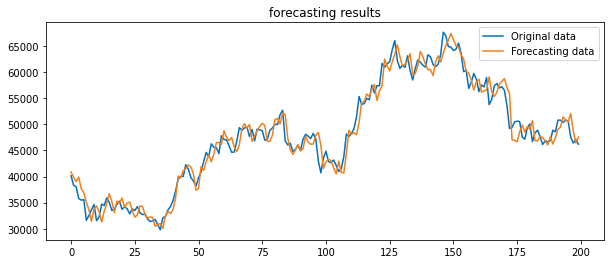

In [185]:
plot_all(pd.array(pred_LR),PERIODS=200)

In [186]:
evl(SERIES[-200:].values, pred_LR)

Model Evaluation 
R2: 0.9585091847554578
RMSE: 1987.185105909024
MAE: 1579.0026744173128
MAPE: 3.3759243128011622


[0.9585091847554578, 1987.185105909024, 1579.0026744173128, 3.3759243128011622]